<a href="https://colab.research.google.com/github/freethechicken/pbh_simulations/blob/main/GRF_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explantions

## 1. **Random Sampling (CPU)**:
The full list of all possible sampling in numpy can be found in the following [link](https://numpy.org/doc/1.16/reference/routines.random.html).
## 2. **GPU computation**:
GPU computation of the random field is given by [Cupy](https://cupy.dev/).

##  3. **Simulation of Gaussian Random Field**

  - Generate the (normal distributed) white noise field $\langle n(\vec x) n(\vec y) \rangle \propto \delta^3(\vec x, \vec y)$.

  - Perform Fast Fourier transform to obtain noise field of unit amplitude $\langle n(\vec k) n(-\vec k) \rangle = 1$

  - Obtain the fourier ampltide by multiplying the white noise field with the
 power spectrum:
$\langle \phi(\vec k)\phi(-\vec k)\rangle'=\langle n(\vec k) n(-\vec k) \rangle \times P(k)$ for $P(k) \equiv {A}{ \lvert k \rvert^{-d}}$.
  - Inverse Fast Fourier transform to obtain the gaussian field.

  - References: Gaussian Random Field is constructed out of [the following website](https://garrettgoon.com/gaussian-fields/).

### **Parameters for Field Simulation:**

- `amplitude`: amplitude of spectrum $A$
- `k_power` : power law of the spectrum $d$
- `pixel` : pixels, size of the plots
- `mean` : mean of the gaussian distribution
- `std_dev` : standard deviation of the gaussian distribution
- `decay_rate` : decay rate of the exponential distribution
- `expected_occurrences_rate ` : expected occurrences rate of the poisson distribution

## 4. **Clustering Algorithm**
### 4.1 **Density-based spatial clustering of applications with noise (DBSCAN)**:
  This algorithm defines clusters as continuous regions of high density.
  - For each instance, the algorithm counts the number of instances within a small distance ϵ (*epsilon*). This region is called the instance’s ϵ-neighborhood.
  - If an instance has at least min_samples instances within its ϵ-neighborhood (includingitself), then it is considered a core instance. Core instances are those that are located in dense regions.
  - All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.
  - Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.

### **Parameters**
  - `eps` : distance parameter $ϵ$
  - `min_samples` : Minimum amount of instasnces required in a $ϵ$ neighborhood
  - `Cluster -1` : Instances that are not a core instance. Marked in black color.




In [ ]:
# @title Import packages

import numpy as np
#import cupy as cp
import matplotlib.pyplot as plt
import imageio
import os
import gc

from scipy.special import erf
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D

# 1. Define functions

In [ ]:
# @title 1.1 Random sampling
def gaussian_white_noise(pixel, mean, std_dev):

    # Generate a 2D grid of white noise from a normal pdf
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))
    return white_noise


def gaussian_white_noise_3d(pixel, z_pixel, mean, std_dev):

    # Generate a 3D grid of white noise from a normal distribution
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel, z_pixel))
    return white_noise


In [ ]:
# @title 1.2 Random field simulations
def gpu_grf_2d(white_noise, pixel, amplitude, k_power):
    # Transfer white noise to GPU
    white_noise_gpu = cp.asarray(white_noise)

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = cp.fft.fft2(white_noise_gpu)

    # Generating FFT momentum
    kx = cp.fft.fftfreq(pixel)*pixel
    ky = cp.fft.fftfreq(pixel)*pixel

    # Genearting FFT momentum 2D array
    kx_grid, ky_grid = cp.meshgrid(kx, ky)
    #k_grid = np.meshgrid(kx, ky)

    # Norm of k
    k_norm =  cp.sqrt( kx_grid**2 + ky_grid**2 ) # k = sqrt( kx^2 + ky^2 )
    k_norm[0][0] = cp.inf # Regularize divergence at k=0

    # Power Spectrum P_k
    power_spectrum = amplitude*(((2 * cp.pi/pixel)*k_norm)**(-1*k_power))  # P(k)=amplitude/k^{power},

    power_spectrum_gpu = cp.asarray(power_spectrum)
    # Multiply the power spectrum with the transformed white noise using GPU-accelerated FFT
    fourier_amplitudes_sqrt_gpu = cp.sqrt(power_spectrum_gpu) * cp.fft.fft2(white_noise_gpu)

    # Perform inverse Fourier transform on GPU to obtain the Gaussian random field
    gaussian_random_field_gpu = cp.fft.ifft2(fourier_amplitudes_sqrt_gpu).real

    # Transfer the result back to CPU
    gaussian_random_field = cp.asnumpy(gaussian_random_field_gpu)

    return gaussian_random_field


def gpu_grf_3d(white_noise, pixel, z_pixel, amplitude, k_power):
    # Transfer white noise to GPU
    white_noise_gpu = cp.asarray(white_noise)

    # 3D Fast Fourier transform of the white noise
    fft_white_noise = cp.fft.fftn(white_noise_gpu)

    # Generating FFT momentum
    kx = cp.fft.fftfreq(pixel)*pixel
    ky = cp.fft.fftfreq(pixel)*pixel
    kz = cp.fft.fftfreq(z_pixel)*z_pixel

    # Genearting FFT momentum 3D array
    kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz)
    # k_grid = np.meshgrid(kx, ky, kz)

    # Norm of k
    k_norm =  cp.sqrt( kx_grid**2 + ky_grid**2 + kz_grid**2 ) # k = sqrt( kx^2 + ky^2  + kz^2 )
    k_norm[0][0] = cp.inf # Regularize divergence at k=0

    # Power Spectrum P_k
    power_spectrum = amplitude*(((2 * cp.pi/pixel)*k_norm)**(-1*k_power))  # P(k)=amplitude/k^{power},

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = cp.sqrt(power_spectrum)*fft_white_noise


    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real

    # Transfer the result back to CPU
    gaussian_random_field = cp.asnumpy(gaussian_random_field)

    return gaussian_random_field

##@profile
def grf_2d(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel) * pixel
    ky = np.fft.fftfreq(pixel) * pixel

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = np.sqrt(kx_grid**2 + ky_grid**2)
    k_norm[0, 0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = amplitude * (((2 * np.pi / pixel) * k_norm) ** (-k_power))
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field


def grf_3d(mean, std_dev, pixel, z_pixel, amplitude, k_power):
    # 3D Fast Fourier transform of the white noise
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel, z_pixel))
    fft_white_noise = np.fft.fftn(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel)*pixel
    ky = np.fft.fftfreq(pixel)*pixel
    kz = np.fft.fftfreq(z_pixel)*z_pixel

    # Genearting FFT momentum 3D array
    kx_grid, ky_grid, kz_grid = np.meshgrid(kx, ky, kz)
    del kx, ky, kz
    gc.collect()
    # k_grid = np.meshgrid(kx, ky, kz)

    # Norm of k
    k_norm =  np.sqrt( kx_grid**2 + ky_grid**2 + kz_grid**2 ) # k = sqrt( kx^2 + ky^2  + kz^2 )
    k_norm[0][0] = np.inf # Regularize divergence at k=0

    # Power Spectrum P_k
    power_spectrum = amplitude*(((2*np.pi/pixel)*k_norm)**(-1*k_power))  # P(k)=amplitude/k^{power},
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifftn(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field

def grf_2d_32f(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel)).astype(np.float32)

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = (np.fft.fftfreq(pixel) * pixel)
    ky = (np.fft.fftfreq(pixel) * pixel)

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = np.sqrt(kx_grid**2 + ky_grid**2).astype(np.float32)
    k_norm[0, 0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = (amplitude * (((2 * np.pi / pixel) * k_norm) ** (-k_power))).astype(np.float32)
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = (np.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise)
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real.astype(np.float32)
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field



def grf_3d_32f(mean, std_dev, pixel, z_pixel, amplitude, k_power):
    # 3D Fast Fourier transform of the white noise
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel, z_pixel)).astype(np.float32)
    fft_white_noise = np.fft.fftn(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = (np.fft.fftfreq(pixel)*pixel)
    ky = (np.fft.fftfreq(pixel)*pixel)
    kz = (np.fft.fftfreq(z_pixel)*z_pixel)

    # Genearting FFT momentum 3D array
    kx_grid, ky_grid, kz_grid = np.meshgrid(kx, ky, kz)
    del kx, ky, kz
    gc.collect()
    # k_grid = np.meshgrid(kx, ky, kz)

    # Norm of k
    k_norm =  np.sqrt( kx_grid**2 + ky_grid**2 + kz_grid**2 ).astype(np.float32) # k = sqrt( kx^2 + ky^2  + kz^2 )
    k_norm[0][0] = np.inf # Regularize divergence at k=0

    # Power Spectrum P_k
    power_spectrum = (amplitude*(((2*np.pi/pixel)*k_norm)**(-1*k_power))).astype(np.float32)  # P(k)=amplitude/k^{power},
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    # fourier_amplitudes_sqrt = (np.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise).astype(np.float32)
    fourier_amplitudes_sqrt = (np.sqrt(power_spectrum)*fft_white_noise)
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifftn(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field



def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)

In [ ]:
# @title 1.2b Chunk Random Field simulation (Working in progress)




def gaussian_random_field_2d_with_chunking(white_noise, total_size, chunk_size, overlap, amplitude, k_power):
    # Initialize the full field
    full_field = np.zeros((total_size, total_size))

    # Calculate the number of chunks
    num_chunks = total_size // chunk_size

    # Iterate over each chunk
    for ii in range(num_chunks):
        for jj in range(num_chunks):
            # Calculate the start and end indices for the chunk
            x_start = max(ii * chunk_size  , 0)
            x_end = min(start_x + chunk_size, total_size)
            y_start = max(jj * chunk_size  , 0)
            y_end = min(start_y + chunk_size, total_size)

            # Generate white noise for the chunk
            white_noise = np.random.normal(size=(chunk_size, chunk_size))

            # Simulate the chunk
            grf_chunk = grf_3d_32f(white_noise, chunk_size, amplitude, k_power)

            # Merge the chunk into the full field with weighted averaging in the overlap regions
            weights = np.ones_like(grf_chunk)
            if i > 0:  # If not the first chunk in x, blend with the left chunk
                weights[:, :overlap] = np.linspace(0, 1, overlap)
            if j > 0:  # If not the first chunk in y, blend with the top chunk
                weights[:overlap, :] *= np.linspace(0, 1, overlap)[:, None]

            # Apply the weights and add the chunk to the full field
            full_field[start_x:end_x, start_y:end_y] += grf_chunk * weights

    return full_field



In [ ]:
# @title 1.3 Plotting and filtering funtcions


def plot_grf_2d(fig, ratio, min_val, max_val):
    # Normalize the field values
    fig = fig/(ratio*np.max(fig))

    plt.imshow(fig, cmap='rainbow', clim=[min_val, max_val])
    #BrBG bwr rainbow
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title('Field Configuration')
    plt.figure(figsize=(20, 20))
    plt.show()


def plot_exprf_2d(fig, ratio, min_val, max_val):
    # Normalize the field values
    fig = fig/(ratio*np.max(fig))

    plt.imshow(fig, cmap='Blues', clim=[min_val, max_val])
    #BrBG bwr rainbow
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title('Field Configuration')
    plt.figure(figsize=(20, 20))
    plt.show()

def plot_dense_by_ratio_2d(fig, ratio):
    ratio = 0.5
    contrast_ratio = 1

    cut_off = ratio*np.max(fig)

    # Create a boolean mask for elements greater than the cutoff
    mask = np.abs(fig) > cut_off
    # Find the matrix compoents greater than the cutoff value
    # Normalize the field values
    dense_position = np.where(mask, fig, 0)
    dense_position = dense_position/(contrast_ratio*np.max(dense_position))

    return dense_position

def plot_dense_by_ratio_3d(fig, ratio):
    ratio = 0.5
    cut_off = ratio*np.max(fig)
    # Create a boolean mask for elements greater than the cutoff
    mask = np.abs(fig) > cut_off
    # Find the indices of elements greater than the cutoff
    dense_position = np.where(mask, fig, 0)
    return(dense_position)

def dense_fraction_2d(grf,pixel):
    # An array of ratios ranging from 0 to 1
    test_ratios = np.linspace(0, 1, num=100)

    # Initialize an empty list
    dense_numbers = []
    # Calculate dense numbers for different ratios
    for ratio in test_ratios:
        # Define the cut off values
        cut_off = ratio * np.max(grf)
        mask = np.abs(grf) > cut_off
        dense_number = np.sum(mask)/(pixel**2)
        dense_numbers.append(dense_number)

    # Plot dense numbers against ratios
    plt.figure(figsize=(6, 6))
    plt.plot(test_ratios, dense_numbers, color='b', linewidth=2)
    plt.xlabel('Ratio')
    plt.ylabel('Precentages of Dense Elements')
    plt.title('Precentages of Dense Elements vs. Ratio')
    plt.grid(True)

def dense_fraction_3d(grf,pixel,z_pixel):
    # An array of ratios ranging from 0 to 1
    test_ratios = np.linspace(0, 1, num=100)

    # Initialize an empty list
    dense_numbers = []
    # Calculate dense numbers for different ratios
    for ratio in test_ratios:
        # Define the cut off values
        cut_off = ratio * np.max(grf)
        mask = np.abs(grf) > cut_off
        dense_number = np.sum(mask)/(pixel*pixel*z_pixel)
        dense_numbers.append(dense_number)

    # Plot dense numbers against ratios
    plt.figure(figsize=(6, 6))
    plt.plot(test_ratios, dense_numbers, color='b', linewidth=2)
    plt.xlabel('Ratio')
    plt.ylabel('Precentages of Dense Elements')
    plt.title('Precentages of Dense Elements vs. Ratio')
    plt.grid(True)

def plot_3d_scatter_field(figs, threshold):
    # Normalize the field values
    normalized_fig = figs / np.abs(figs).max()

    # Create 3D meshgrid
    x, y, z = np.meshgrid(range(exprf.shape[0]),
                          range(exprf.shape[1]),
                          range(exprf.shape[2]))

    # Transparency based on normalized field values
    alphas = 0.5 + 0.5 * (1 - normalized_fig)

    figu = plt.figure(figsize=(6, 6))
    ax = figu.add_subplot(111, projection='3d')

    # Plot scatters above the threshold values
    scatterplts = ax.scatter(x[np.abs(normalized_fig) > threshold],
                            y[np.abs(normalized_fig)  > threshold],
                            z[np.abs(normalized_fig)  > threshold],
                            c=normalized_fig[np.abs(normalized_fig) > threshold],
                            s=5,
                            cmap='viridis')
    #                        alpha=alphas[np.abs(normalized_fig) > threshold])

    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.set_title(f'3D Field Config: (Threshold = { np.abs(figs).max()*threshold:.1f})', fontsize=14)
    figu.colorbar(scatterplts, ax=ax, label='Field Amplitude', shrink=0.5)
    figu.patch.set_facecolor('white')

    plt.show()

In [ ]:
# @title 1.4 DBSCAN

def DB_SCAN(figs, eps, min_samples, cutoff):
    #cutoff = np.max(np.abs(fig))*cutoff_ratio
    mask = np.abs(figs) > cutoff

    positions = np.argwhere(mask)

    # Apply DBSCAN to the position array
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(positions)

    # Visualization
    plt.figure(figsize=(5, 5))
    for ii in np.unique(labels):
        cluster_index = np.where(labels == ii )[0]
        cluster_positions = positions[cluster_index]
        if ii == -1:
            plt.scatter(
                cluster_positions[:, 1], -cluster_positions[:, 0],
                s=3,  color='black', facecolor='none', label='Anomaly'
            )
        else:
            plt.scatter(
                cluster_positions[:, 1], -cluster_positions[:, 0],
                s=3,  label=f'Cluster {ii}'
            )

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(0,pixel)
    plt.ylim(-pixel,0)
    plt.title('Clustered Field Configurations')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

    return dbscan, mask, positions


def DB_SCAN_3D(figs, eps, min_samples, cutoff):

    mask = np.abs(figs) > cutoff
    positions = np.argwhere(mask)

    del figs
    gc.collect()

    # Apply DBSCAN to the position array
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(positions)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    for ii in set(labels):
        cluster_index = np.where(labels == ii)[0]
        cluster_positions = positions[cluster_index]

        if ii == -1:
            ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                       s=3, color='black', label='Anomaly')
        else:
            ax.scatter(-cluster_positions[:, 0], cluster_positions[:, 1], cluster_positions[:, 2],
                       s=3, label=f'Cluster {ii}')

    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)
    ax.set_title(f'Clustered 3D Field Config: (Threshold = {cutoff:.1f})', fontsize=14)
    #ax.set_xlim(0, pixel)
    #ax.set_ylim(0, pixel)
    #ax.set_zlim(0, pixel)
    plt.legend()
    plt.show()

    return dbscan, mask, positions

def cluster_distances(labels, positions):

    # Find unique cluster labels (excluding noise -1)
    unique_labels = set(labels) - {-1}

    # Calculate cluster centers
    cluster_centers = {}
    for ii in unique_labels:
        cluster_indices = np.where(labels == ii)[0]
        cluster_positions = positions[cluster_indices]
        cluster_center = np.mean(cluster_positions, axis=0)
        cluster_centers[ii] = cluster_center

    # Calculate distances between cluster centers
    distances = []
    for aa in cluster_centers:
        for bb in cluster_centers:
            if aa != bb & bb > aa:
                distance = euclidean_distances([cluster_centers[aa]], [cluster_centers[bb]])
                distances.append((aa,bb, distance))

    return distances

def cluster_distribution(fig, labels, positions):
    unique_labels = set(labels)

    all_cluster_position = {}
    cluster_field_values={}
    for ii in unique_labels:
        cluster_indices = np.where(labels == ii)[0]
        all_cluster_position[ii+1] = positions[cluster_indices]
        cluster_field_values[ii+1] = fig[all_cluster_position[ii+1][:,0] , all_cluster_position[ii+1][:,1]]


    for ii in unique_labels:
        plt.hist(cluster_field_values[ii+1].flatten(), bins = 100, label=f'Cluster {ii}', alpha=0.3)
        #plt.yscale('log')
        plt.xlabel('Field amplitude')
        plt.ylabel('Number of samples')
        plt.title(f'Cluster Distribution')
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
        plt.grid(True)

    return cluster_field_values

def cluster_distribution_3d(fig, labels, positions):

    all_cluster_position = {}
    cluster_field_values={}
    for ii in set(labels):
        cluster_indices = np.where(labels == ii)[0]
        all_cluster_position[ii+1] = positions[cluster_indices]
        cluster_field_values[ii+1] = fig[all_cluster_position[ii+1][:,0],
                                         all_cluster_position[ii+1][:,1],
                                         all_cluster_position[ii+1][:,2]]

    for ii in set(labels):
        plt.hist(cluster_field_values[ii+1].flatten(), bins = 100, label=f'Cluster {ii}', alpha=0.3);
        #plt.yscale('log')
        plt.xlabel('Field amplitude')
        plt.ylabel('Number of samples')
        plt.title(f'Cluster Distribution')
        plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
        plt.grid(True)

    return cluster_field_values

# 2. **Main**

In [ ]:
# @title Parameters
amplitude = 1 # amplitude of the power spectrum
k_power = 3 # power of k in the power spectrum

# Define the size of the square grid
pixel = 2**10  # 2^8 = 256
z_pixel = 2**7 # Reduce ram usage
chunk_size = 2**8

# Parameters for the normal distribution
mean = 0      # Mean
std_dev = 1   # Standard deviation
# Parameters for exponential decay
decay_rate = 1

## 2.1 2D Model

In [ ]:
# @title Run 2D Model (GPU/CPU)
#  Run 2D Model (GPU)
#grf  = gpu_grf_2d(gaussian_white_noise(pixel,mean,std_dev), pixel, amplitude, k_power)

#  Run 2D Model (CPU) [Inactive]
#grf = gaussian_random_field_2d(mean,std_dev, pixel, amplitude, k_power) # gaussian white noise
grf = grf_2d(mean,std_dev, pixel, amplitude, k_power) # gaussian white noise

# Run 2D Model with chunking
#grfc, white_noise = overlap_chunking_gaussian_random_field_2d(gaussian_white_noise(pixel,mean,std_dev), pixel, amplitude, k_power, chunk_size, overlap_size) # gaussian white noise


#%load_ext memory_profiler
#%mprun -f  gaussian_random_field_2d gaussian_random_field_2d(mean,std_dev, pixel, amplitude, k_power)
#%mprun -f  gaussian_random_field_2d_optimized gaussian_random_field_2d_optimized(mean,std_dev, pixel, amplitude, k_power)

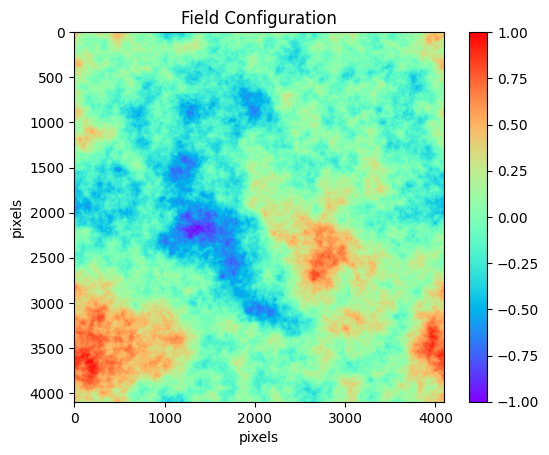

<Figure size 2000x2000 with 0 Axes>

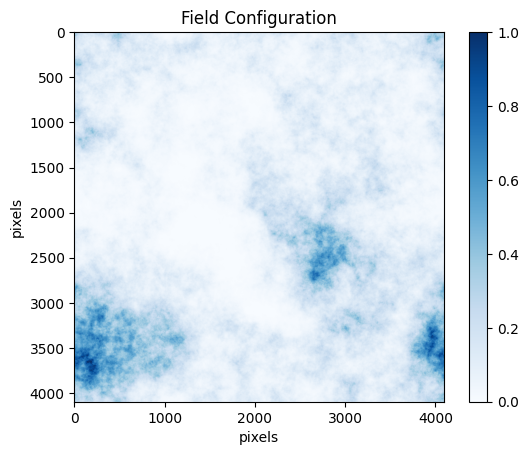

<Figure size 2000x2000 with 0 Axes>

In [ ]:
# @title Plot 2D figures

plot_grf_2d(grf, ratio=0.95, min_val=-1, max_val= 1 ) # Gaussian random field
exprf = gaussian_to_exp(grf, decay_rate)
plot_exprf_2d(exprf, ratio=0.9, min_val=0, max_val= 1 ) # Exponentially distorted field

#plot_grf_2d(grfc, ratio=0.95, min_val=-1, max_val= 1 ) # Gaussian random field [Chunk]
#exprfc = gaussian_to_exp(grfc, decay_rate)
#plot_exprf_2d(exprfc, ratio=0.9, min_val=0, max_val= 1 ) # Exponentially distorted field [Chunk]

#dense_data = plot_dense_by_ratio_2d(grf, ratio=0.45)
#plot_grf_2d(dense_data, ratio=0.66)
#dense_fraction_2d(grf,pixel)

In [ ]:
all_points = exprf.flatten()
exprf_std = np.std(all_points)
sigma_cutoff = np.mean(all_points)+ exprf_std*6
print(sigma_cutoff)

7.475087702952882


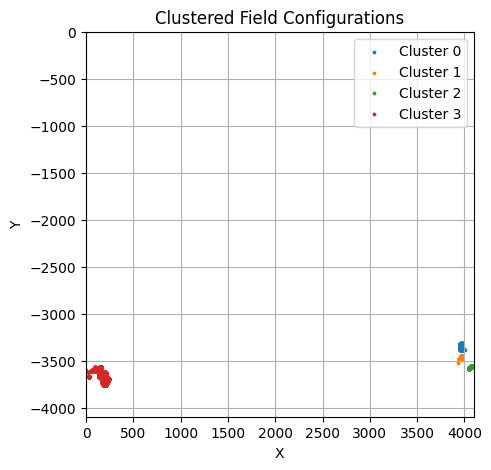

In [ ]:
# @title Cluster distances and positions

dbscan_cluster_data, mask, position_array = DB_SCAN(exprf, eps=50, min_samples=10, cutoff= sigma_cutoff)
cluster_distances(dbscan_cluster_data.labels_, position_array);
#plt.imshow(mask, cmap='binary')

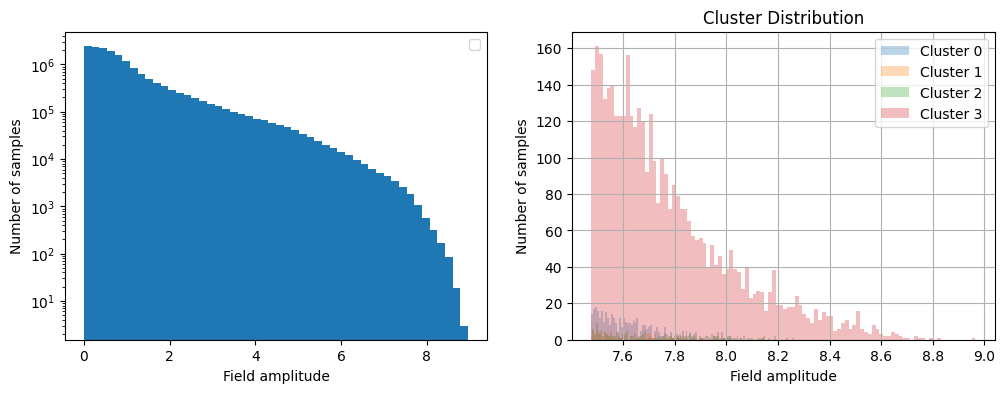

In [ ]:
# @title Cluster fields values distribution

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(exprf.flatten(),bins=50);
plt.yscale('log')
plt.xlabel('Field amplitude')
plt.ylabel('Number of samples')
plt.legend()

plt.subplot(122)
all_cluster_position = cluster_distribution(exprf, dbscan_cluster_data.labels_, position_array )

In [ ]:
# @title Noise samples (Inactive)
# Plot the white noise grid as a grayscale image

#plt.imshow(white_noise, cmap='rainbow', clim=[-std_dev , std_dev ])
#plt.colorbar()
#plt.xlabel('pixels')
#plt.ylabel('pixels')
#plt.title('White Noise Sample')
#plt.figure(figsize=(20, 20))
#plt.show()

## 2.2 3D Model

In [ ]:
# @title Run 3D Model

# Run 3D Model (GPU)
#grf, white_noise_3d = gpu_grf_3d(gaussian_white_noise_3d(pixel, z_pixel, mean, std_dev), pixel, z_pixel, amplitude, k_power)
# Run 3D Model (CPU)
grf =  grf_3d_32f( mean, std_dev, pixel, z_pixel, amplitude, k_power)
exprf = gaussian_to_exp(grf, decay_rate)



In [ ]:
all_points_3d = exprf.flatten()
exprf_std_3d = np.std(all_points_3d)
exprf_mean_3d = np.mean(all_points_3d)
sigma_cutoff_3d = exprf_mean_3d + exprf_std_3d*6
print(exprf_std_3d)
print(exprf_mean_3d)
print(sigma_cutoff_3d)

del grf, all_points_3d
gc.collect()

1.0074723111066228
1.000844383334406
7.045678249974142


0

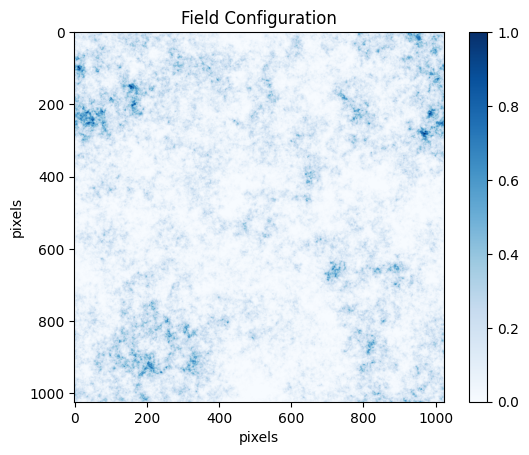

<Figure size 2000x2000 with 0 Axes>

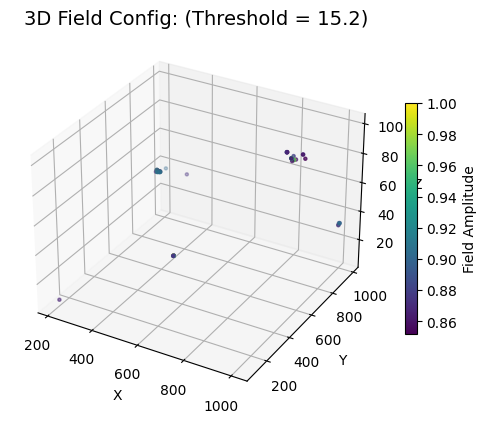

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


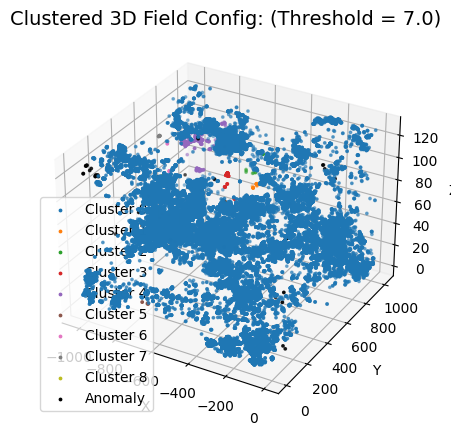

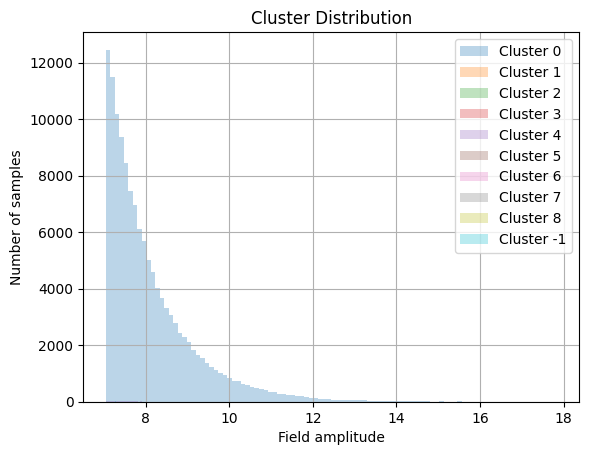

In [ ]:
# @title 3D Visualization and Clustering
threshold_ratio = 0.85
plot_exprf_2d(exprf[:,:,0], ratio= threshold_ratio, min_val=0, max_val= 1 ) # Exponentially distorted field
plot_3d_scatter_field(exprf, threshold = threshold_ratio)
dbscan_3d, mask_3d, positions_3d = DB_SCAN_3D(exprf, 45, 10, sigma_cutoff_3d)
all_cluster_field_values = cluster_distribution_3d(exprf, dbscan_3d.labels_, positions_3d)

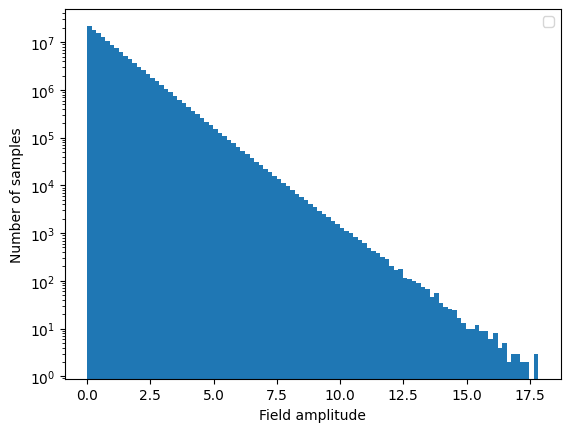

In [ ]:
plt.hist(exprf.flatten(),bins=100);
plt.yscale('log')
plt.xlabel('Field amplitude')
plt.ylabel('Number of samples')
plt.legend()

## 2.x 3D Visualization Video (OLD)

In [ ]:
# @title Video for 3D Visualization
# Normalize the field values
ratio = 0.66 # 0.0001
grf = grf / (ratio * np.max(grf))

# Create a list to store individual frames for the GIF
frames = []

# Loop through the third dimension (z-axis) of the grf array
for z in range(grf.shape[2]):
    # Extract 2D slice at the current z-coordinate
    grf_slice = grf[:, :, z]

    # Plot the 2D slice
    plt.imshow(grf_slice, cmap='Blues', clim=[0, 1])
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title(f'Gaussian Random Field (z = {z})')
    # Save the current plot as a frame
    plt.savefig(f'frame_{z:04d}.png')
    plt.close()  # Close the plot for the next iteration

    # Append the saved frame to the frames list
    frames.append(f'frame_{z:04d}.png')

# Create a GIF from the saved frames using imageio
#with imageio.get_writer('grf_animation.gif', mode='I', duration=0.001) as writer:
with imageio.get_writer('grf_animation.mp4', format='FFMPEG', mode='I', fps=30 ) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)
        # Remove the temporary frame files after appending to the GIF
        os.remove(frame)

<ipython-input-10-2ab82a4a7184>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


In [ ]:
# @title Video for 3D Visualization of dense regime
# Normalize the field values
grf_dense = plot_dense_by_ratio_3d(grf,0.33)

grf_dense = grf_dense / (np.max(grf_dense))
# Create a list to store individual frames for the GIF
frames = []

# Loop through the third dimension (z-axis) of the grf array
for z in range(grf_dense.shape[2]):
    # Extract 2D slice at the current z-coordinate
    grf_dense_slice = grf_dense[:, :, z]

    # Plot the 2D slice
    plt.imshow(grf_dense_slice, cmap='rainbow', clim=[-1, 1])
    plt.colorbar()
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title(f'Gaussian Random Field (z = {z})')
    # Save the current plot as a frame
    plt.savefig(f'frame_{z:04d}.png')
    plt.close()  # Close the plot for the next iteration

    # Append the saved frame to the frames list
    frames.append(f'frame_{z:04d}.png')

# Create a GIF from the saved frames using imageio
#with imageio.get_writer('grf_animation.gif', mode='I', duration=0.001) as writer:
with imageio.get_writer('od_grf_animation.mp4', format='FFMPEG', mode='I', fps=30 ) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)
        # Remove the temporary frame files after appending to the GIF
        os.remove(frame)

<ipython-input-47-d4c0f2425dd8>:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)
